### Exploratory data analysis & feature engineering

This part will primarily emphasize Exploratory Data Analysis (EDA) while also delving into feature engineering. It comprises the following subsections:

*  **Univariate analysis:** Examining variable distributions, detecting outliers, and assessing skewness.
*  **Variable-to-target correlation:** Analyzing how variables relate to LogP.
*  **Descriptor correlations:** Exploring correlations among descriptors.
*  **Feature engineering:** Enhancing and creating new features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st

### Dataset

Let's read in the data.

In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.columns

Index(['mwt', 'logp', 'rings', 'heavy_atoms', 'hetero_atoms', 'fraction_sp3',
       'charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'rotatable_bonds1',
       'apolar_des1', 'polar_des1', 'RDtpsa', 'RDCfraction'],
      dtype='object')

In [4]:
rename = {'mwt':'Molecular weight [g/mol]','logp':'LogP','rings':'No. of rings', 'RDtpsa':'Topologic Polar Surface Area [Å]', 'Hbond_donors1':'No. of H-hond donors', 'Hbond_acceptors1':'No. of H-bond acceptors', 'rotatable_bonds1':'No. of rotatable bonds', 'heavy_atoms':'No. of heavy atoms', 'hetero_atoms':'No. of hetero atoms', 'fraction_sp3':'Fraction of sp3 hybridized carbons', 'charge1':'Charge', 'apolar_des1':'Apolar desolvation free energy', 'polar_des1':'Polar desolvation free energy','RDCfraction':'Fraction of heavy atoms that are carbons' }

The original data has **13 features**. Their full names are listed in the dictionary above.

Before we move further let's describe the parameters briefly.
*  **mwt** - molecular weight
*  **heavy_atoms** - the number of non-hydrogen atoms in the molecule
*  **hetero_atoms** - the number of atoms in the molecule, excluding hydrogens and carbons
*  **fraction_sp3** - the number of sp3 hybridized carbons divided by the total number of carbons in the molecule
*  **Hbond_donors1** - the number of hydrogen atoms able to engage in hydrogen bonds
*  **Hbond acceptors1** - the number of hetero-atoms able to engage in hydrogen bonds
*  **rotatable_bonds1** - the number of non-terminal sigma-bonds that are not part of a cycle
*  **RDtpsa** - Topologic Polar Surface Area is an approximate measure of the PSA, which is the sum of van-Der-Waals surface of polar atoms
*  **apolar_des1 & polar_des1** - two components of the desolvation free energy, i.e. the free energy necessary to bring the solute from the solvent to the gas phase, corresponding to electrostatic and non-electrostatic interactions with the solute, respectively.
*  **RDCfraction** - fraction of heavy atoms that are carbons 

In this study our target variable is **LogP - octanol-water partition coefficient** which is a measure of how hydrophilic or hydrophobic a molecule is.

In [5]:
X=df.drop(['logp'], axis=1)
y=df['logp']

The data need to be split into **training-validation** and **test set** in order to keep some unseen data (unseen during feature engineering and hyperparameter tuning) to evaluate and compare different models which will be developed in this study. For this purpose let's keep **20 %** of data.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [7]:
original_features = X_train.columns
print(f'The size of the \033[1mtrain set\033[0m is: \033[1m{len(X_train)}\033[0m and the size of the \033[1mtest set\033[0m is: \033[1m{len(X_test)}\033[0m')

The size of the train set is: 49094 and the size of the test set is: 12274


### 1. Univariate data analysis

Let's have a quick look at the data.

In [8]:
X_train.describe()

,mwt,rings,heavy_atoms,hetero_atoms,fraction_sp3,charge1,Hbond_donors1,Hbond_acceptors1,rotatable_bonds1,apolar_des1,polar_des1,RDtpsa,RDCfraction
count,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000,49094.000000
mean,284.717027,2.501650,19.845643,5.165051,0.248705,-0.055995,0.848148,3.700513,3.078788,6.907651,-17.832121,56.739194,0.735581
std,46.819988,0.845816,3.501091,1.622387,0.183605,0.426236,0.802306,1.543611,1.526010,2.783868,16.102032,22.346297,0.083161
min,102.133000,0.000000,7.000000,2.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,-7.740000,-229.340000,0.000000,0.500000
25%,254.241000,2.000000,18.000000,4.000000,0.110000,0.000000,0.000000,3.000000,2.000000,5.200000,-17.110000,39.440000,0.684211
50%,293.330000,2.000000,20.000000,5.000000,0.220000,0.000000,1.000000,4.000000,3.000000,7.140000,-11.830000,55.130000,0.739130
75%,323.392000,3.000000,23.000000,6.000000,0.360000,0.000000,1.000000,5.000000,4.000000,8.880000,-9.040000,70.830000,0.800000
max,355.441000,8.000000,27.000000,11.000000,1.000000,2.000000,6.000000,11.000000,11.000000,17.580000,-0.980000,149.820000,0.904762


As we can see above (and we've seen before during cleaning the dataset) **no data is missing** and all the values are in **reasonable range** from a chemical point of view.

However to get more insight into the data let's have a closer look at the distribution of each variable.

####     a. The distribution of logP

Let's start with the distribution of our **target variable: logP**

<AxesSubplot:xlabel='logp', ylabel='Count'>

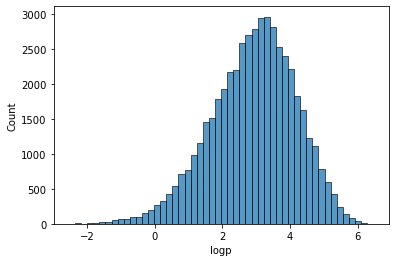

In [9]:
sns.histplot(x=y_train, bins =50)

Above we can see that the values in the histogram are quite concentrated with no outliers which could be interpreted as erronous data (they are all in a reasonable range from the chemical point of view). LogP is our target variable and we will leave its values intact. 

####     b. The distribution of other variables

#####     b1. outliers

Let's start by plotting **histograms** of all descriptors. To make it easier to determine which points could potentially be outliers let's add lines indicating limits of **outliers** calculated as **z-score** (with n=3) and **interquartile range** (with n=1.5).

In [10]:
def outliers_lim_IQR(v, n=1.5):
    """
    finds limits of inliners with IQR method. 
    you can set the scaling factor n to some other value, e.g. 2 or 3
    """
    Q1 = v.quantile(0.25)
    Q3 = v.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - n * IQR
    upper_lim = Q3 + n * IQR
    
    return lower_lim, upper_lim

In [11]:
def outliers_lim_zscore(v, n=3):
    """
    finds limits of inliners with z-score method
    """
    mean = np.mean(v)
    std = np.std(v)
    lower_lim = mean - n*std
    upper_lim = mean + n*std
    
    return lower_lim, upper_lim    

------------------ Molecular weight [g/mol] -----------------------------


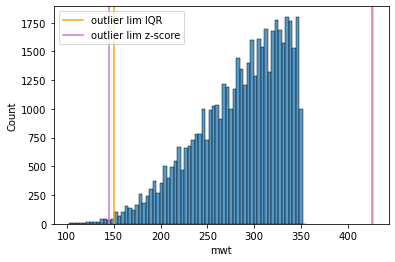

------------------ No. of rings -----------------------------


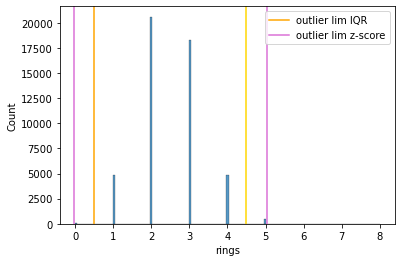

------------------ No. of heavy atoms -----------------------------


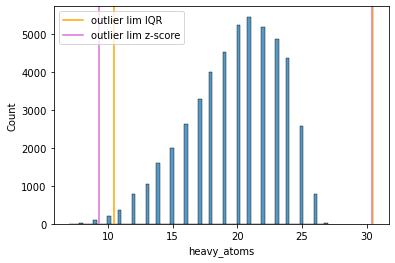

------------------ No. of hetero atoms -----------------------------


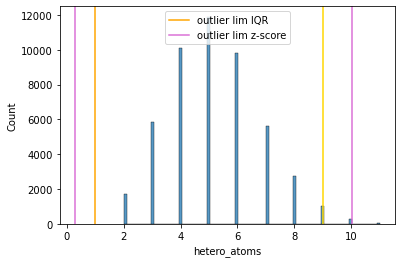

------------------ Fraction of sp3 hybridized carbons -----------------------------


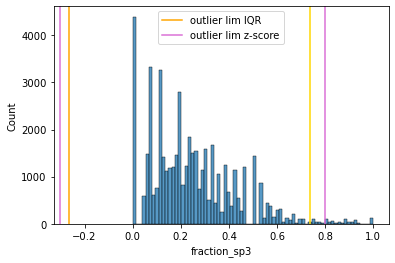

------------------ Charge -----------------------------


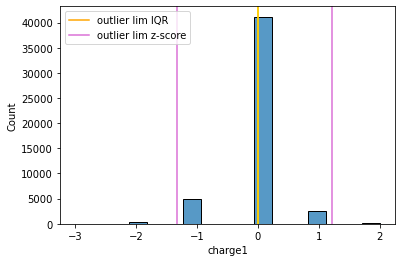

------------------ No. of H-hond donors -----------------------------


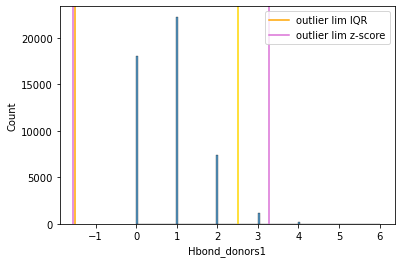

------------------ No. of H-bond acceptors -----------------------------


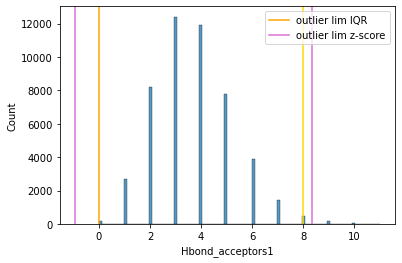

------------------ No. of rotatable bonds -----------------------------


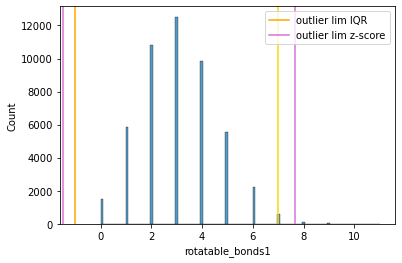

------------------ Apolar desolvation free energy -----------------------------


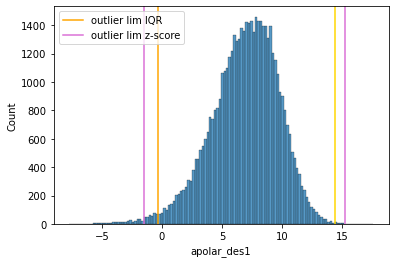

------------------ Polar desolvation free energy -----------------------------


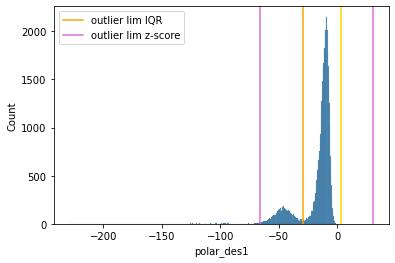

------------------ Topologic Polar Surface Area [Å] -----------------------------


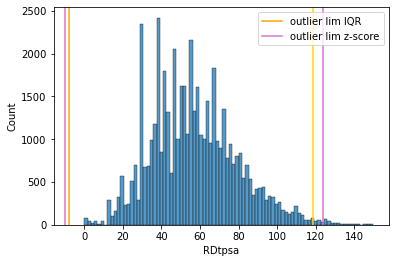

------------------ Fraction of heavy atoms that are carbons -----------------------------


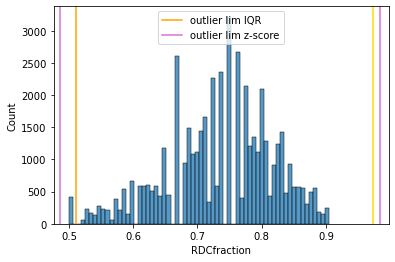

In [12]:
for col in X_train.select_dtypes(include=[np.number]):
    print('\033[1m------------------ '+ rename[col] +' -----------------------------\033[0m')
    sns.histplot(X_train, x=col)
    outl = outliers_lim_IQR(df[col])
    out2 = outliers_lim_zscore(df[col])
    plt.axvline(x=outl[0], ymin=0, ymax=1, color = 'orange', label='outlier lim IQR')
    plt.axvline(x=outl[1], ymin=0, ymax=1, color = 'gold')
    plt.axvline(x=out2[0], ymin=0, ymax=1, color = 'orchid', label='outlier lim z-score')
    plt.axvline(x=out2[1], ymin=0, ymax=1, color = 'orchid')
    plt.legend()
    plt.show()


Above, the following observations can be made.
* Molecular weight and the no. of heavy atoms have a clear cut-off for higher values which is related to the fact that ZINC database is held for small molecules.
* All values seem to be more or less i the range determined by the lines (IQR or z-score method) with no obvious outliers. There is no reason to remove or modify any values, as all the points seem to belong to the population. The only distribution which caught my attention was **polar desolvation**. Let's have a closer look at the values lying in the left tail of the distribution where it visually reaches more or less 0 (I would say at around the value of _polar_des1_ of -80). 

In [13]:
# filtering observations where polar desolvation is less than -80
polar_des_outliers = X_train[X_train['polar_des1'] < (-80)]

# checking how many observations have these values
percentile = st.percentileofscore(df['polar_des1'], -80)
print(f'This accounts for {percentile:.2} % of the data which is {len(polar_des_outliers)} records')

This accounts for 0.75 % of the data which is 369 records


Let's have a look at the **comparison of distributions** of the descriptors **between** the records we selected above (with **polar_des1 < -80**) **and the whole population**.

------------------ Molecular weight [g/mol] -----------------------------


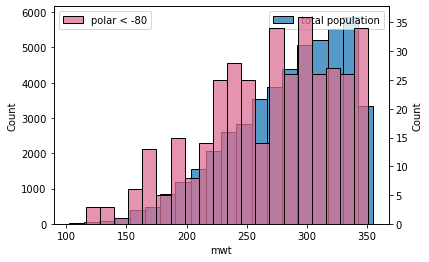

------------------ No. of rings -----------------------------


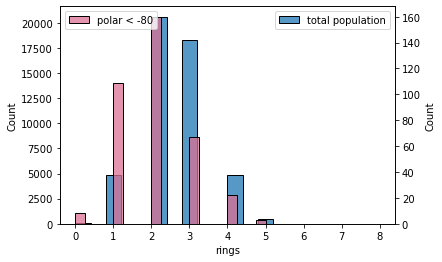

------------------ No. of heavy atoms -----------------------------


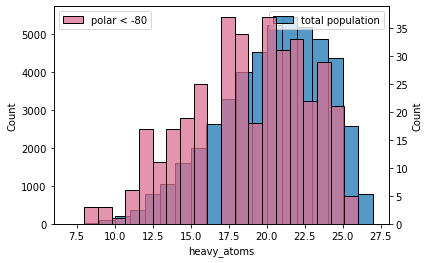

------------------ No. of hetero atoms -----------------------------


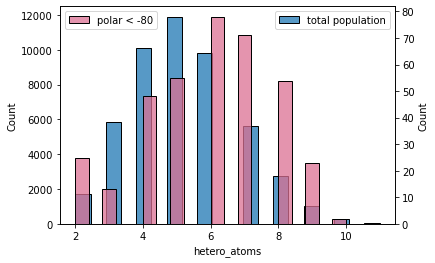

------------------ Fraction of sp3 hybridized carbons -----------------------------


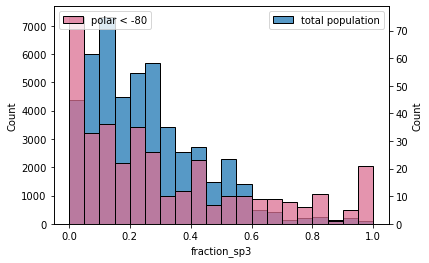

------------------ Charge -----------------------------


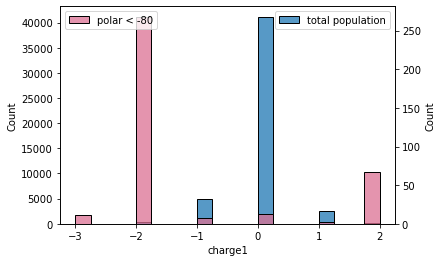

------------------ No. of H-hond donors -----------------------------


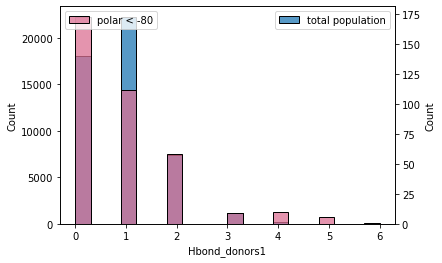

------------------ No. of H-bond acceptors -----------------------------


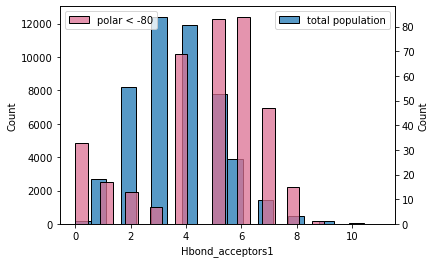

------------------ No. of rotatable bonds -----------------------------


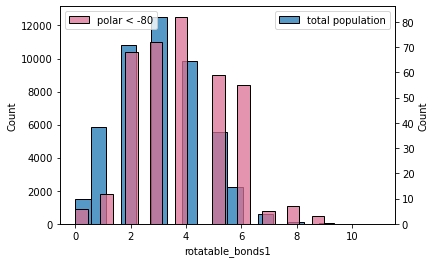

------------------ Apolar desolvation free energy -----------------------------


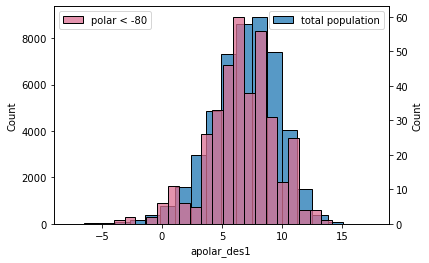

------------------ Polar desolvation free energy -----------------------------


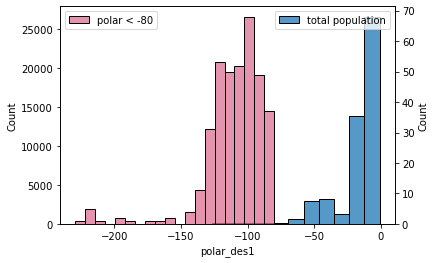

------------------ Topologic Polar Surface Area [Å] -----------------------------


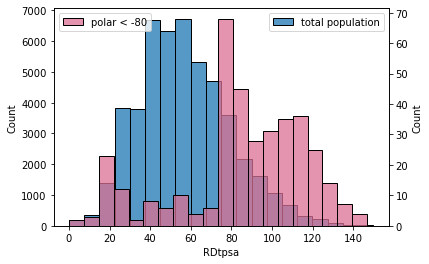

------------------ Fraction of heavy atoms that are carbons -----------------------------


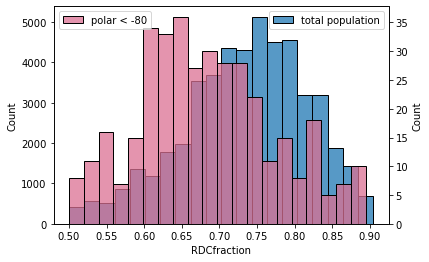

In [14]:
for col in X_train.select_dtypes(include=[np.number]):
    print('\033[1m------------------ '+ rename[col] +' -----------------------------\033[0m')
    fig=plt.figure(figsize=(6, 4))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    sns.histplot(polar_des_outliers, x=col, ax=ax2, color='palevioletred', bins=20, label='polar < -80')
    sns.histplot(X_train, x=col, ax=ax1, bins=20, label='total population')
    plt.legend(loc='upper left')
    ax1.legend(loc='upper right')
    plt.show()


Distributions of most of the parameters seem to be comparable between the selected records and the whole population except for the parameters we would expect to be related to the **polar desolvation free energy**, such as **charge** (there is more charged particles among particles with high absolute values of polar desolvation), **H-bond acceptors** (its higher values are observed for higher absolute polarities) and **Topologic Polar Surface Area** (it's high values are observed for high absolute values of polar desolvation).

The above paragraph shows that the extreme values of the polar desolvation free energy are supported by other related parameters, hence they are not erronous. For this reason I would avoid removing them or modifying their value (e.g. by winsorizing) as they carry valuable chemical information. However, during model optimization, it is worth considering a standardization method that is not sensitive to outliers, such as sklearn **RobustScaler**.

#####    b1. skeweness of the distributions 

As we have already seen, most of the distributions do not look anything close to normal. Since a significant part of the variables are discrete, performing normality test will not be helpful. However, we can have a look at the skewness of the distributions.

In [15]:
skewness_original = X_train.select_dtypes(include=[np.number]).skew().sort_values()
skewness_original

polar_des1         -2.793498
mwt                -0.720890
charge1            -0.688186
heavy_atoms        -0.520225
apolar_des1        -0.512829
RDCfraction        -0.439053
rings               0.266501
rotatable_bonds1    0.312776
hetero_atoms        0.336178
Hbond_acceptors1    0.463418
RDtpsa              0.503988
Hbond_donors1       0.868899
fraction_sp3        0.985355
dtype: float64

To **stabilize the variance** and address the issue of **skewness**, let's assess the impact of the **PowerTransformer** on the distributions. The PowerTransformer achieves variance stabilization by adjusting the data using either a logarithmic function or other power functions. This is making the data more suitable for certain statistical and machine learning methods.

In [16]:
from sklearn.preprocessing import PowerTransformer

# making transformed data set
pt = PowerTransformer()
X_train_pt_transformed = pd.DataFrame(pt.fit_transform(X_train.select_dtypes(include=[np.number])))

# adding column names to the transformed data
column_names = X_train.columns
pt_column_names = ['PT_' + x for x in column_names]
X_train_pt_transformed.columns = pt_column_names

To assess the influence of **PowerTransformer** on the data, let's create histograms for the variables **before and after** the transformation, along with information about their skewness.

------------------ Molecular weight [g/mol] -----------------------------
mwt


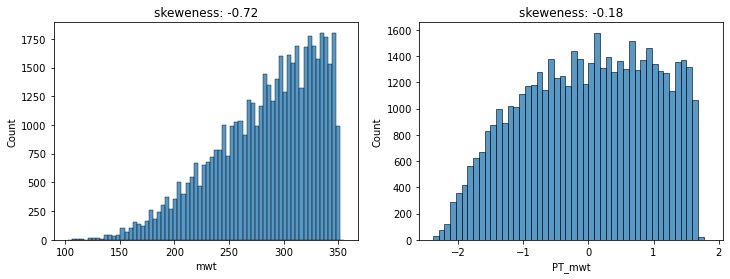

------------------ No. of rings -----------------------------
rings


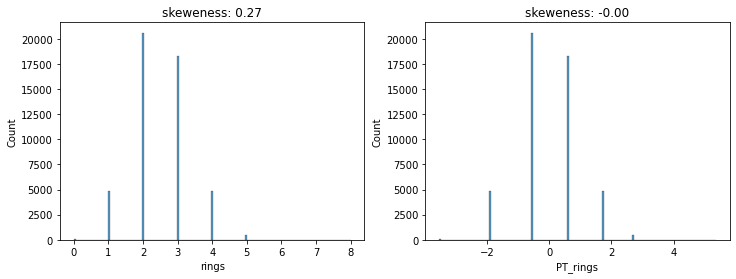

------------------ No. of heavy atoms -----------------------------
heavy_atoms


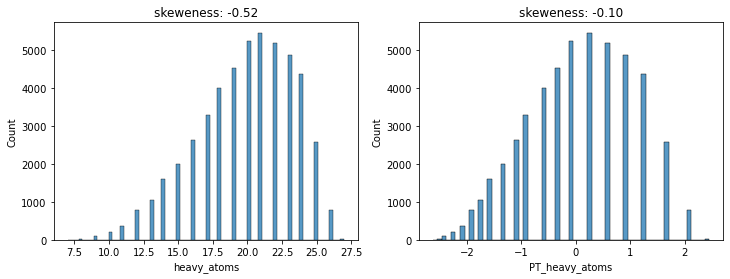

------------------ No. of hetero atoms -----------------------------
hetero_atoms


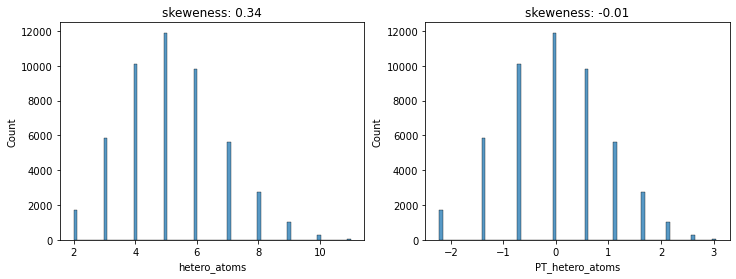

------------------ Fraction of sp3 hybridized carbons -----------------------------
fraction_sp3


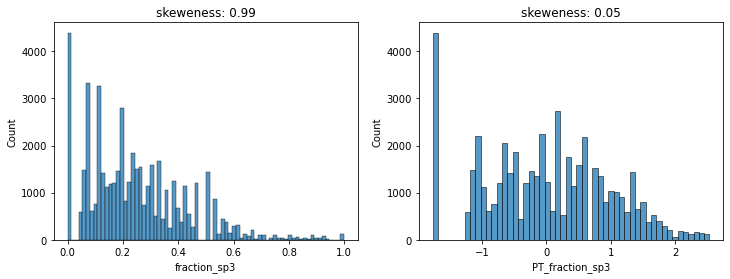

------------------ Charge -----------------------------
charge1


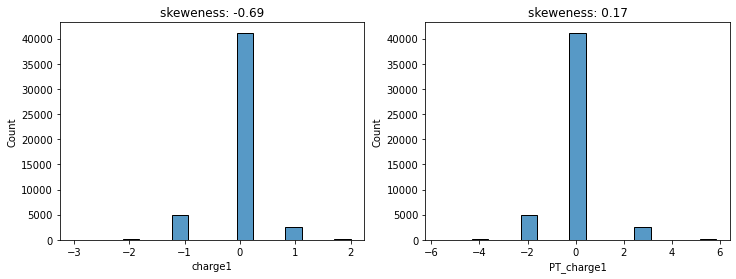

------------------ No. of H-hond donors -----------------------------
Hbond_donors1


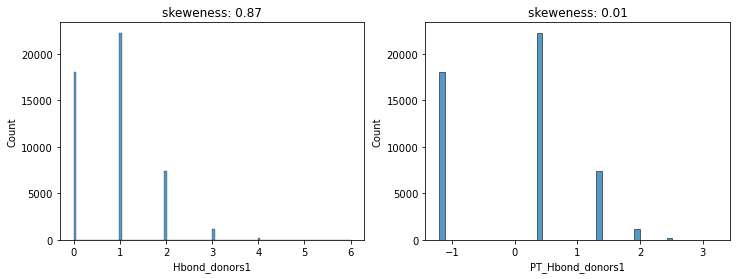

------------------ No. of H-bond acceptors -----------------------------
Hbond_acceptors1


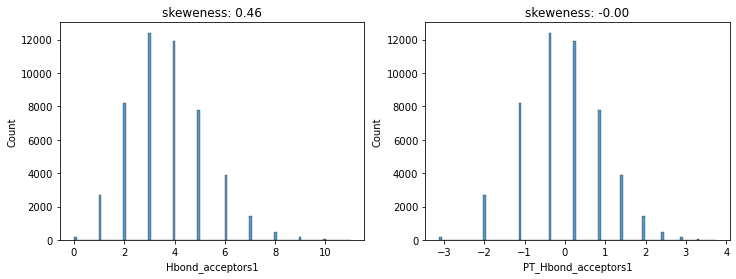

------------------ No. of rotatable bonds -----------------------------
rotatable_bonds1


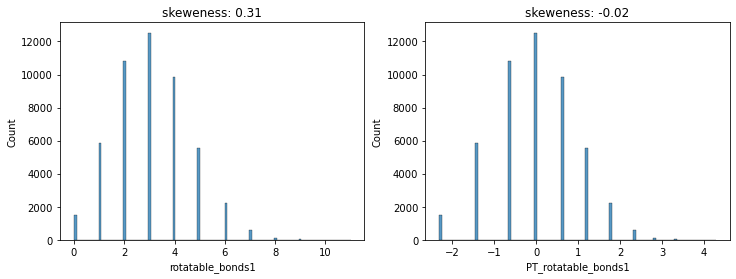

------------------ Apolar desolvation free energy -----------------------------
apolar_des1


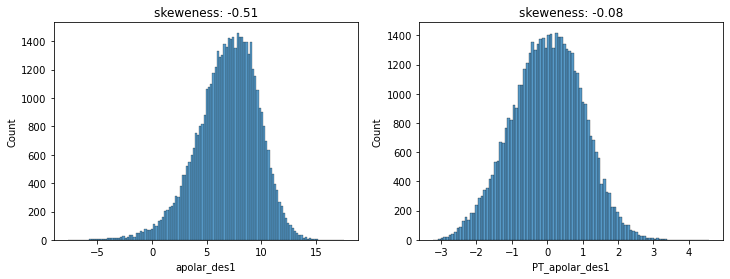

------------------ Polar desolvation free energy -----------------------------
polar_des1


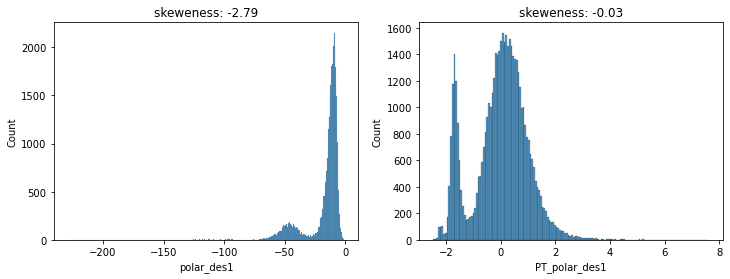

------------------ Topologic Polar Surface Area [Å] -----------------------------
RDtpsa


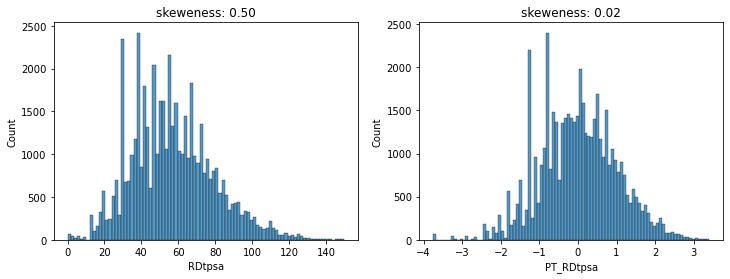

------------------ Fraction of heavy atoms that are carbons -----------------------------
RDCfraction


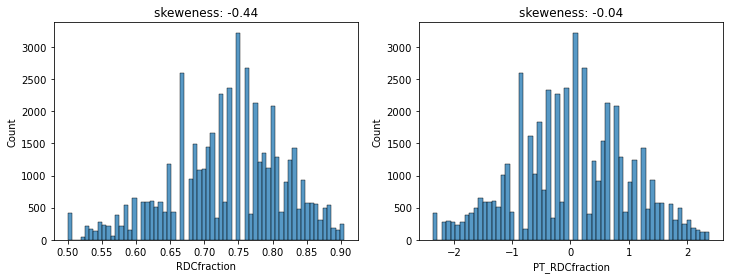

In [17]:
# check the skewness after the transformation
skewness_pt_transformed = X_train_pt_transformed.skew()
# plot the histograms
for col in X_train:
    print('\033[1m------------------ '+ rename[col] +' -----------------------------\033[0m')
    print(col)
    
    # plot both original and transformed data
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(X_train, x=col, ax=ax1)
    sns.histplot(X_train_pt_transformed, x='PT_'+col, ax=ax2)
    ax1.title.set_text('skeweness: {:.2f}'.format(skewness_original[col]))
    ax2.title.set_text('skeweness: {:.2f}'.format(skewness_pt_transformed['PT_'+col]))
    plt.show()

Both visual evaluation of the histograms and comparison of the skewness before and after the transformation suggest this step is worth further exploration. To avoid data leakage, **PowerTransformer** will be applied to the data **directly in pipelines** implementing models tested in this study.

### 2. Correlations of descriptors with LogP

To gain a deeper understanding of significance of individual variables, let's examine their correlation with the target value (logP).

For improved visual accessibility of the data and easier pattern identification, the discrete variables were represented using boxplots. Likewise, continuous variables were binned and depicted using the same boxplot visualization.

In [18]:
discrete = ['heavy_atoms','hetero_atoms','rotatable_bonds1','rings','charge1','Hbond_donors1','Hbond_acceptors1' ]
continous = ['mwt','fraction_sp3','RDtpsa','apolar_des1','polar_des1','RDCfraction']

In [19]:
# to avoid modifying original data let's make a copy
df_copy = pd.concat([X_train.copy(), y_train], axis=1)

------------------ Fraction of heavy atoms that are carbons -----------------------------


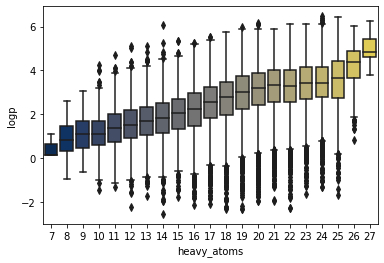

------------------ Fraction of heavy atoms that are carbons -----------------------------


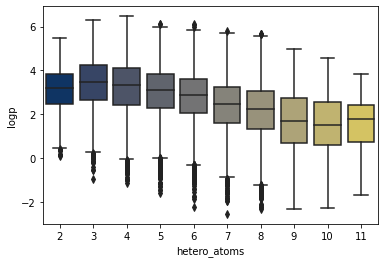

------------------ Fraction of heavy atoms that are carbons -----------------------------


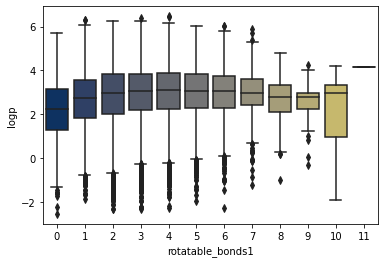

------------------ Fraction of heavy atoms that are carbons -----------------------------


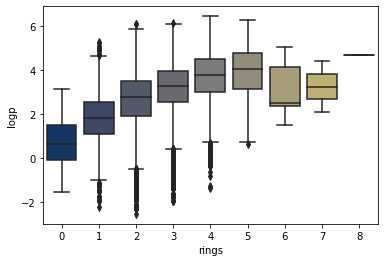

------------------ Fraction of heavy atoms that are carbons -----------------------------


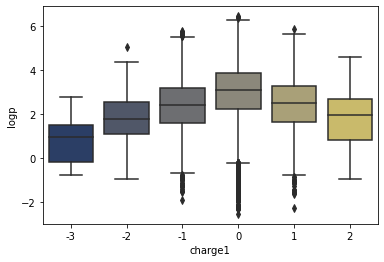

------------------ Fraction of heavy atoms that are carbons -----------------------------


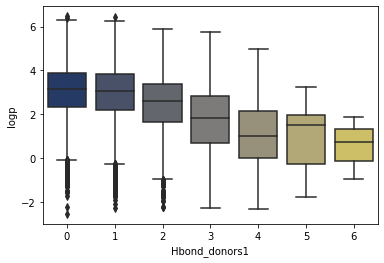

------------------ Fraction of heavy atoms that are carbons -----------------------------


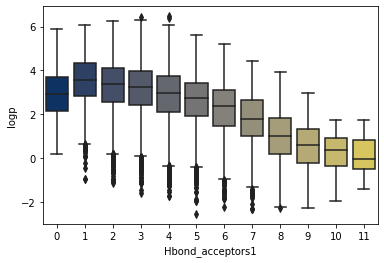

In [20]:
# plot discrete features
for feature in discrete:
    print('\033[1m------------------ '+ rename[col] +' -----------------------------\033[0m')
    sns.boxplot(data=df_copy, x=feature, y='logp', palette = 'cividis')
    plt.show()

------------------ Fraction of heavy atoms that are carbons -----------------------------


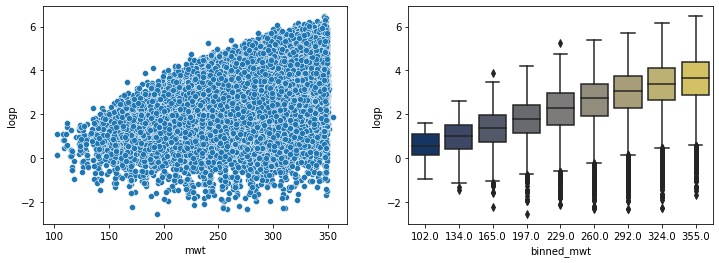

------------------ Fraction of heavy atoms that are carbons -----------------------------


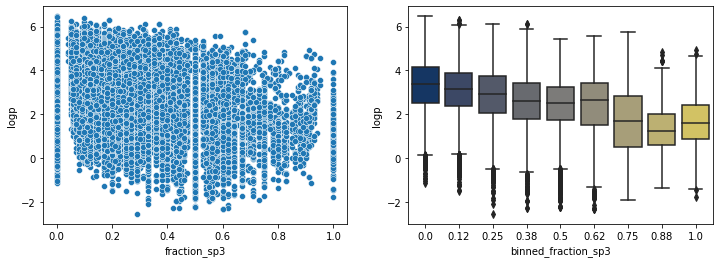

------------------ Fraction of heavy atoms that are carbons -----------------------------


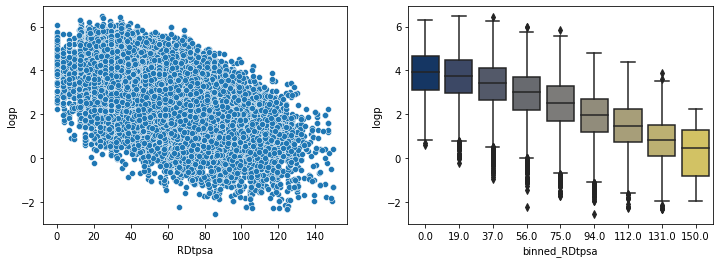

------------------ Fraction of heavy atoms that are carbons -----------------------------


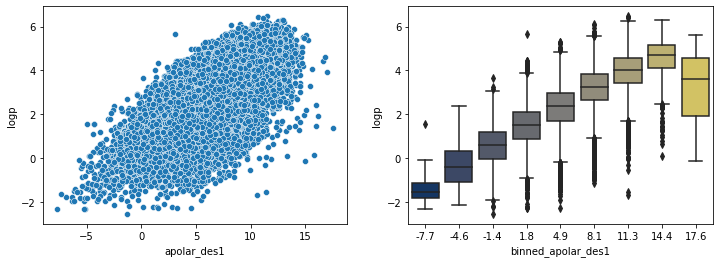

------------------ Fraction of heavy atoms that are carbons -----------------------------


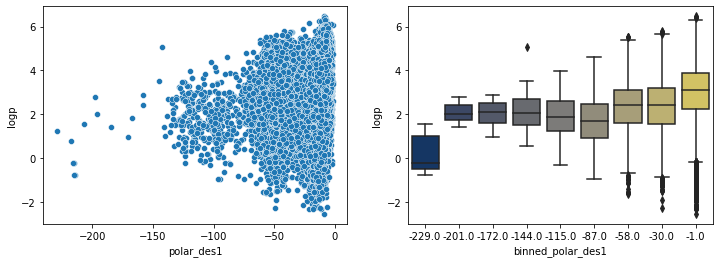

------------------ Fraction of heavy atoms that are carbons -----------------------------


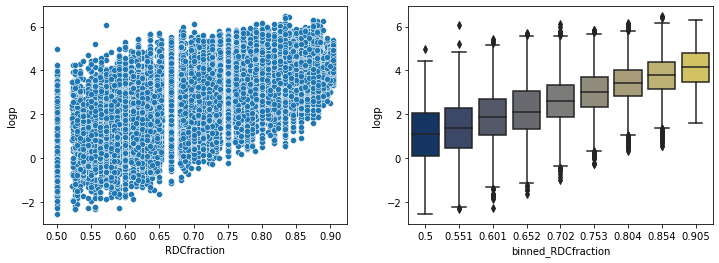

In [21]:
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plot continous features
for feature in continous:
    print('\033[1m------------------ '+ rename[col] +' -----------------------------\033[0m')
    
    # bin the data
    min_value, max_value = df_copy[feature].min(), df_copy[feature].max()
    x_range = '{:.1e}'.format((max_value - min_value))
    bins = np.linspace(min_value, max_value, 10)
    labels = np.linspace(min_value, max_value, 9).round(-(int(x_range.split('e')[1])-2))
    name = 'binned_' + feature
    df_copy[name] = pd.cut(df_copy[feature], bins=bins, labels=labels, include_lowest=True)
    
    # plot both original and binned data
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    sns.scatterplot(data=df_copy, x=feature, y='logp', ax=ax1, palette = 'cividis')
    sns.boxplot(data=df_copy, x=name, y='logp', ax=ax2, palette ="cividis")
    plt.show()

A glance at the graphs suggests that the dependence of logP on some variables is not linear and would be **better represented by a polynomial function**. This is apparent, among others, for these variables:

In [22]:
features = ['hetero_atoms', 'rotatable_bonds1', 'rings', 'charge1', 'Hbond_acceptors1', 'binned_apolar_des1', 'binned_polar_des1']

To make it more obvious, let's fit a polynomial function of degree 2 and 3 to these plots.

In [23]:
def fit_n_poly(feature, n=2):
    
    # fit the model with n-th order polynomial
    mymodel = np.poly1d(np.polyfit(df_copy[feature], y_train, n))
    
    # define x axis for the fitted line:
    # - if values are discreete keep the original
    # - if values are cotinous make 10 points
    minv =  df_copy[feature].min()
    maxv =  df_copy[feature].max()
    x_range = '{:.1e}'.format((maxv - minv))
    if ((isinstance((maxv-minv), int)) & ((maxv-minv)!=1)): 
        nbins = int(maxv-minv+1)
    else: 
        nbins = 10
    myline = np.linspace(minv, maxv, nbins).round(-(int(x_range.split('e')[1])-2))
    
    return myline, mymodel(myline)

------------------ No. of hetero atoms -----------------------------


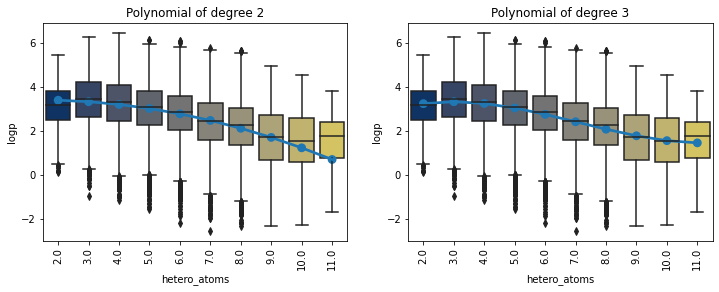

------------------ No. of rotatable bonds -----------------------------


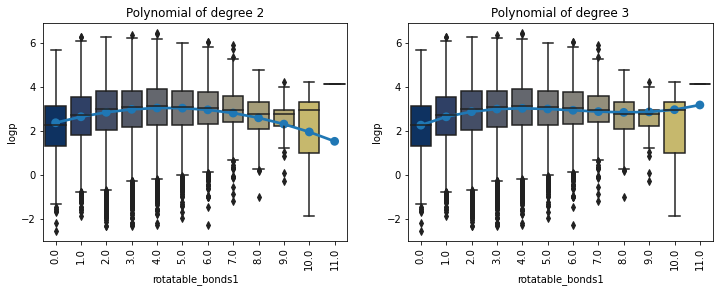

------------------ No. of rings -----------------------------


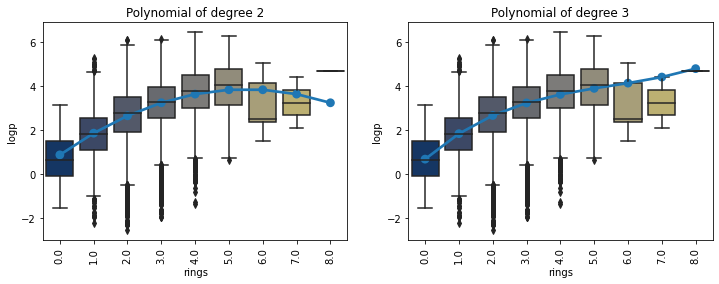

------------------ Charge -----------------------------


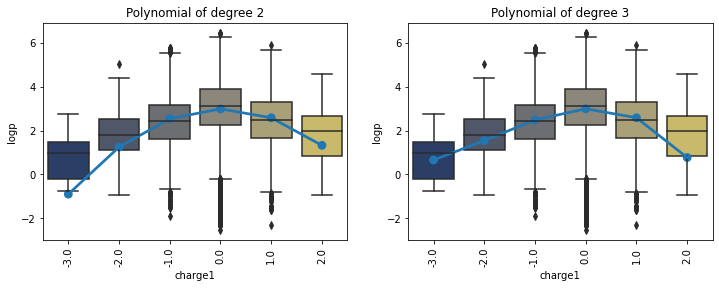

------------------ No. of H-bond acceptors -----------------------------


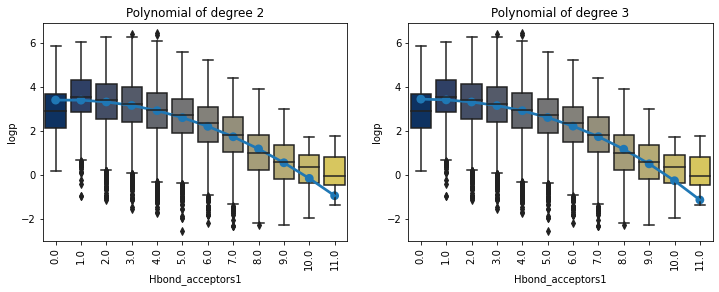

------------------ Apolar desolvation free energy -----------------------------


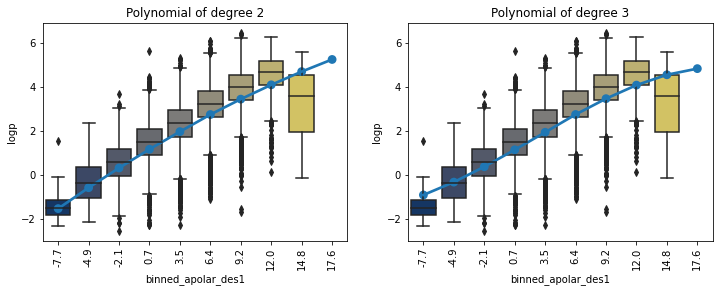

------------------ Polar desolvation free energy -----------------------------


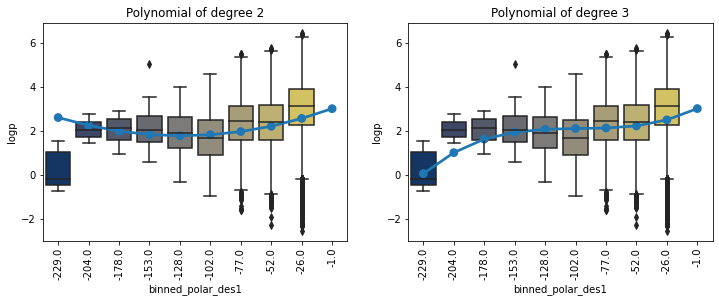

In [24]:
for feature in features:
    print('\033[1m------------------ '+ rename[feature.removeprefix('binned_')] +' -----------------------------\033[0m')
    
    # fits polynomials for the current feature
    x2, y2 = fit_n_poly(feature, n=2)
    x3, y3 = fit_n_poly(feature, n=3)
    
    #Creates a figure with two subplots for the current feature
    fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,4))
    sns.boxplot(data=df_copy, x=feature, y='logp', ax=ax1, palette ='cividis').set_title('Polynomial of degree 2')
    sns.pointplot(x=x2, y=y2, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    sns.boxplot(data=df_copy, x=feature, y='logp', ax=ax2, palette ='cividis').set_title('Polynomial of degree 3')
    sns.pointplot(x=x3, y=y3, ax=ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
    plt.show()

After visual inspection of the figures above it can be concluded that some of the features may benefit from being fitted with polynomial of degree 2 ('rings', 'rotatable_bonds1') and some from being fitted with polynomial of degree 3: 'charge1', 'hetero_atoms', 'binned_polar_des'. Selection of the appropriate degree of the polynomial requires further optimization and will be done as part of pipelines.

To avoid data leakage **PolynomialFeatures** will be applied directly **in the pipelines**.

### 3. Dependencies between other parameters 

Let's examine the **correlations** among the parameters. To ensure the figures remain clear and readible, **interrelated parameters** will be **grouped** together.

#### a. Composition related parameters

such as **molecular weight** ('mwt'), **no. of heavy atoms** ('heavy_atoms'), **no. of hetero atoms** ('hetero_atoms'), **fraction of heavy atoms that are carbons** ('RDCfraction'), **apolar desolvation free energy** ('apolar_des1')

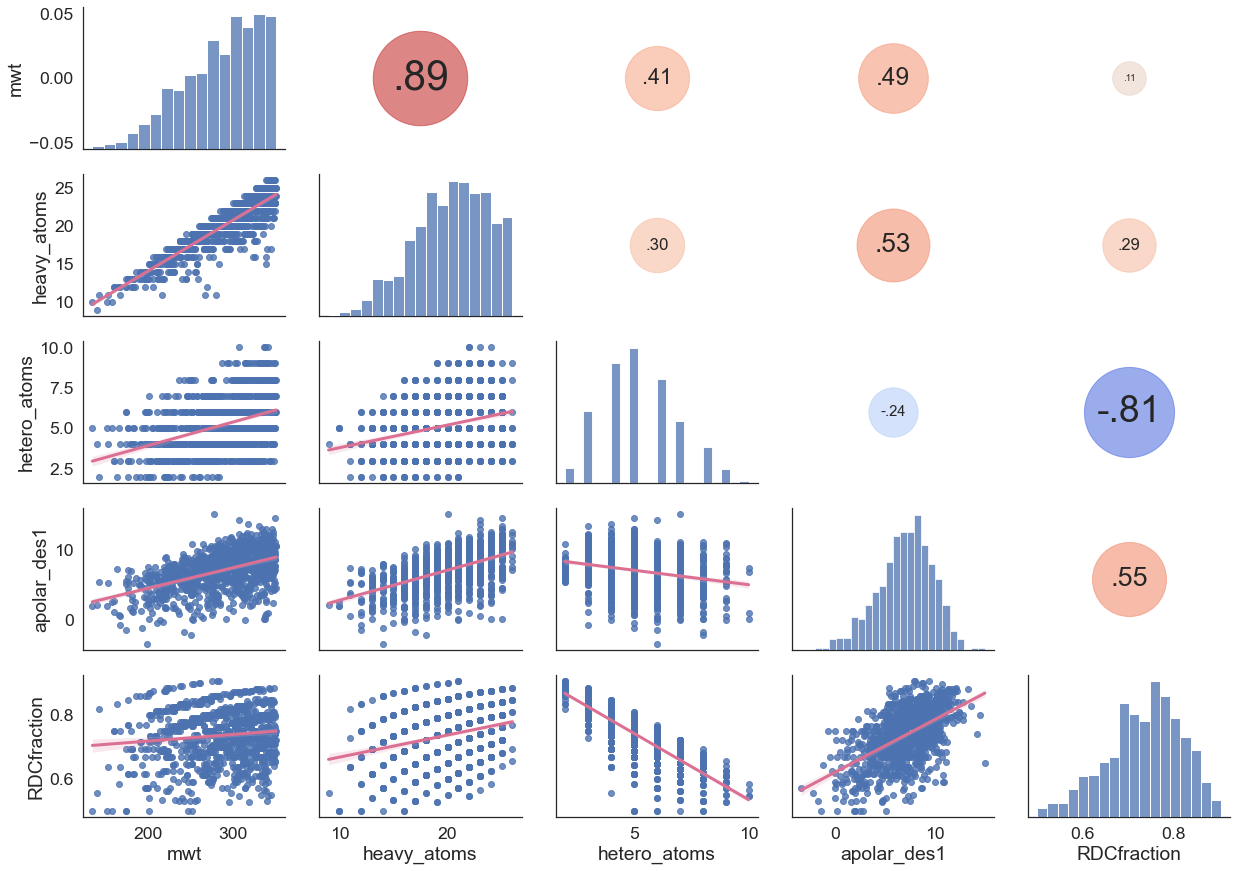

In [25]:
# this part of code is coming from here: https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df[['mwt','heavy_atoms','hetero_atoms','apolar_des1','RDCfraction']].sample(1000), aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, line_kws={'lw': 3, 'color': 'palevioletred'})
g.map_diag(sns.histplot)
g.map_upper(corrdot)

We observe significant correlations among multiple variables. Notably, there is a clear correlation between molecular weight and the count of heavy atoms constituting the molecule. Also, the apolar desolvation free energy is positively correlated with both molecular weight and the number of heavy atoms, which is not surprising, as we expect it to increase with the increasing surface area of the molecule. Additionally, an increase in the number of hetero atoms corresponds to a decrease in the fraction of heavy atoms that are carbons.

By utilizing the aforementioned features, determining the count of carbons becomes straightforward. This prompted me to investigate the correlation between the ratio of hetero atoms to carbons and logP.

In [26]:
# ratio of hetero atoms to carbons
df_copy['carbons'] = (df_copy['heavy_atoms'] - df_copy['hetero_atoms'])
df_copy['carb_to_hetero'] = (df_copy['carbons'] / df_copy['hetero_atoms']).apply(lambda x: round(x, 2))

# the correlation coefficients of the new and original variables
corr_ratio, _ = st.spearmanr(df_copy['carb_to_hetero'],df_copy['logp'])
corr_heavy, _ = st.spearmanr(df_copy['heavy_atoms'],df_copy['logp'])
corr_hetero, _ = st.spearmanr(df_copy['hetero_atoms'],df_copy['logp'])

Text(0.5, 1.0, 'correlation: -0.29')

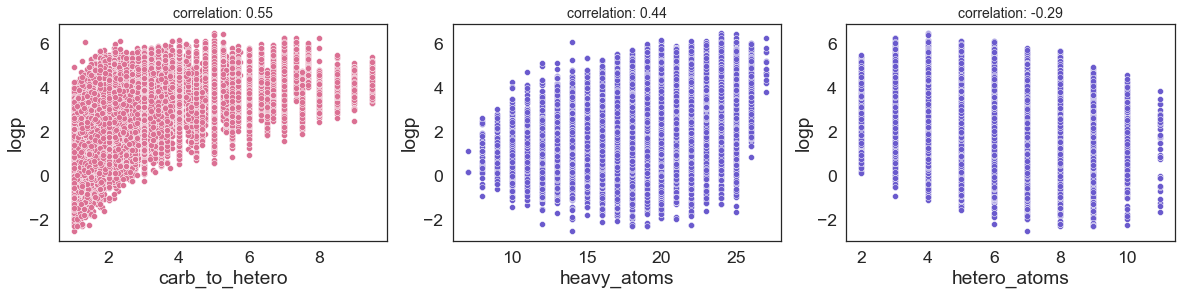

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4))
sns.scatterplot(data=df_copy, y='logp', x='carb_to_hetero', ax=ax1, color='palevioletred').set_title(f'correlation: {corr_ratio:0.2}', fontsize=14)
sns.scatterplot(data=df_copy, y='logp', x='heavy_atoms', ax=ax2, color='slateblue').set_title(f'correlation: {corr_heavy:0.2}', fontsize=14)
sns.scatterplot(data=df_copy, y='logp', x='hetero_atoms', ax=ax3, color='slateblue').set_title(f'correlation: {corr_hetero:0.2}', fontsize=14)

It's evident from the data above that the **new variable exhibits a stronger correlation with LogP** (the target) compared to the original variables. The concept of generating additional variables using differential ratios will be **further explored** in the next phase of this analysis.

#### b. Structure related parameters 

such as: **fraction of sp3 hybridized carbons** ('traction_sp3'), **number of rotatable bonds** ('rotatable_bonds1'), **number of rings** ('rings')

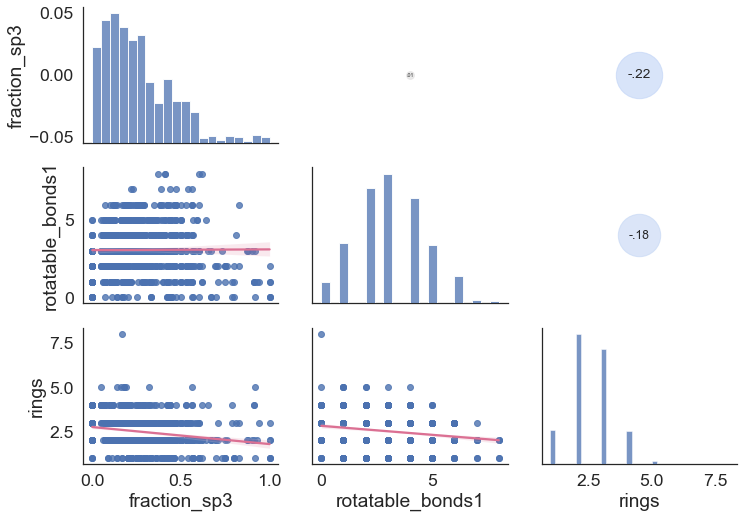

In [28]:
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df[['fraction_sp3', 'rotatable_bonds1', 'rings']].sample(1000), aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, line_kws={'color': 'palevioletred'})
g.map_diag(sns.histplot)
g.map_upper(corrdot)

This set of structure-related parameters doesn't demonstrate any meaningful correlations.

#### c. Charge related parameters 

This includes parameters such as: **charge**, **no. of H-bond donors** , **no. of H-bond acceptors**, **Topologic Polar Surface Area** ('RDtpsa'), **polar desolvation free energy** ('polar_des1').

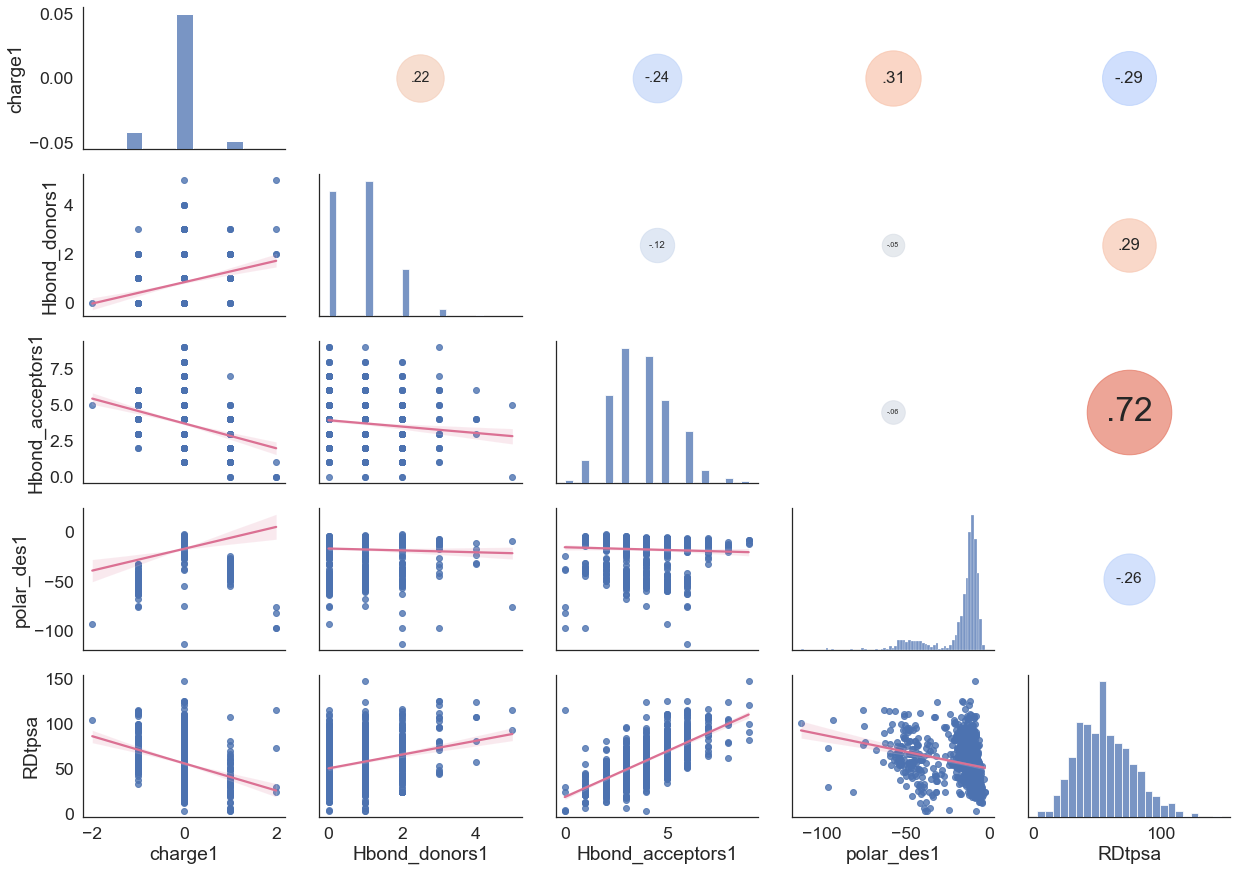

In [29]:
#sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df[['charge1', 'Hbond_donors1', 'Hbond_acceptors1', 'polar_des1', 'RDtpsa']].sample(1000), aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, line_kws={'color': 'palevioletred'})
g.map_diag(sns.histplot)
g.map_upper(corrdot)

The most pronounced correlation within this set of parameters is evident between the number of hydrogen-bond acceptors and the Topological Polar Surface Area. This observation is expected, given that molecules featuring an increased count of hydrogen-bond acceptors, such as oxygen and nitrogen atoms, generally exhibit more polar regions. This polarity arises from the electronegativity of these atoms and the presence of unshared electron pairs (lone pairs).

There's another relationship that isn't strongly indicated by the correlation coefficient, and that's between the molecule's charge and its polar desolvation free energy. As expected, a molecule with a higher absolute charge tends to exhibit a greater polar desolvation free energy.

#### d. Other correlations

To ensure we don't miss any significant correlations, let's examine the correlation coefficient for **all descriptors** together. Only those with a correlation coefficient greater than 0.2 will be displayed.

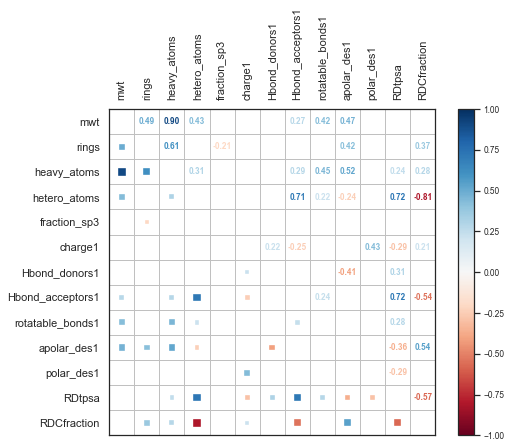

In [30]:
# this part of code is coming from here: https://stackoverflow.com/questions/73581384/plotting-a-fancy-diagonal-correlation-matrix-with-coefficients-in-upper-triangle
sns.set_theme(style="white")

# generate sample correlation matrix
df_original = df[original_features]
#df["label"] = np.random.randint(0, 2, size=len(df))
corr = df_original.corr()

# mask and melt correlation matrix
mask = np.tril(np.ones_like(corr, dtype=bool)) | corr.abs().le(0.2)
melt = corr.mask(mask).melt(ignore_index=False).reset_index()
melt["size"] = melt["value"].abs()

fig, ax = plt.subplots(figsize=(8, 6))

# normalize colorbar
cmap = plt.cm.RdBu
norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize="x-small")

# plot lower triangle (scatter plot with normalized hue and square markers)
sns.scatterplot(ax=ax, data=melt, x="index", y="variable", size="size",
                hue="value", hue_norm=norm, palette=cmap,
                style=0, markers=["s"], legend=False)

# format grid
xmin, xmax = (-0.5, corr.shape[0] - 0.5)
ymin, ymax = (-0.5, corr.shape[1] - 0.5)
ax.vlines(np.arange(xmin, xmax + 1), ymin, ymax, lw=1, color="silver")
ax.hlines(np.arange(ymin, ymax + 1), xmin, xmax, lw=1, color="silver")
ax.set(aspect=1, xlim=(xmin, xmax), ylim=(ymax, ymin), xlabel="", ylabel="")
ax.tick_params(labelbottom=False, labeltop=True)
plt.xticks(rotation=90)

# annotate upper triangle
for y in range(corr.shape[0]):
    for x in range(corr.shape[1]):
        value = corr.mask(mask).to_numpy()[y, x]
        if pd.notna(value):
            plt.text(x, y, f"{value:.2f}", size="x-small",
                     color=sm.to_rgba(value), weight="bold",
                     ha="center", va="center")

In addition to the correlations discussed in previous sections, there are several other notable correlations:
*  The correlation between the count of heteroatoms and the proportion of heavy atoms that are carbons.
*  The correlation between the count of heteroatoms and the number of H-bond acceptors.
*  The correlation between the count of heteroatoms and the Topological Polar Surface Area.

The latter two correlations were previously elucidated when explaining the relationship between H-bond acceptors and the Topological Polar Surface Area.

### 4. Feature engineering

In the preceding sections, following an exploratory data analysis (EDA), two **feature engineering steps** were suggested for this project: employing **PowerTransformer** and **PolynomialFeatures**. These steps will be directly integrated into the pipelines implementing the planned models to prevent any inadvertent data leakage.

In this context, we will delve deeper into the notion of engineering features as **rational differences**, as mentioned in the previous section. The motivation behind engineering features of this nature is rooted in the common observation that models often struggle to synthesize expressions of this type effectively.

Rational differences refer to equations written in this form:

$$\frac{a-b}{c}$$

To prevent potential issues like division by zero and extremely small denominators, let's normalize the data to fall within the range of 0.5 to 1.5. This adjustment helps maintain numerical stability during calculations.

In [31]:
# data copy, to avoid modifying original train and test sets
train = pd.concat([X_train.copy(), y_train], axis=1)
test = pd.concat([X_test.copy(), y_train], axis=1)

In [32]:
from sklearn.preprocessing import MinMaxScaler

for feature in original_features:
    
    # fit the transformer on test data and transform both train and test set
    name = 'S_' + feature
    scaler = MinMaxScaler(feature_range=(0.5,1.5))
    train.loc[:, name] = scaler.fit_transform(train[[feature]])
    test.loc[:, name] = scaler.fit_transform(test[[feature]])

# list of names of scaled features
scaled_features = ['S_' + feature for feature in original_features]

To establish a comparison between the new features and the original ones, let's create a dictionary containing their respective correlations with the target variable (logP). This will serve as a reference to determine the effectiveness of the new features.

In [33]:
feature_correlation = {}

for feature in original_features:
    corr = train[feature].corr(df['logp'])
    feature_correlation[feature] = corr

The new features will be calculated by finding **_a_** and **_b_** (in $\frac{a-b}{c}$) as 2 element combinations of original features. Element **_c_** will be taken from all original features including those already chosen for **_a_** and **_b_**.

Only features which are at least 10% better than each of the original features will be taken into account.

In [35]:
from itertools import combinations  

# find all possible 2 element combinations of features
features_combinations = list(combinations(scaled_features, 2))

# correlation of the new features with logP will be stored in a dictionary
new_feature_correlation = {}

for combination in features_combinations:
    for feature in scaled_features:
        
        # calculate new feature
        new = (train[combination[0]] - train[combination[1]]) / train[feature]
        
        # list all features used as a, b and c respectively
        features_used = (*combination, feature)
        features_used = [el.replace('S_','') for el in features_used]
        
        # check how the new feature correlates with logP
        corr = new.corr(train['logp'])

        # check if the new feature is better correlated (by at least 10 %) than any of the original features
        flag = 1
        for f in features_used:
            if np.absolute(corr) < np.absolute(feature_correlation[f]) * 1.1:
                flag = flag * 0
        
        # and if it has a correlation coefficient of at least 0.5 (filtering out weak correlations)
        #if np.absolute(corr) < 0.5:
        #    flag = flag * 0
            
        # only meaningful correlations will be added to the sets   
        key = '-'.join(features_used)
        
        if flag ==1 :
            # add the correlation coef. of the new feature to the dict.
            new_feature_correlation[key] = corr
            
            # add new feature to the datasets
            train.loc[:, key] = new
            test.loc[:, key] = (test[combination[0]] - test[combination[1]]) / test[feature]

Within the **original features**, the **highest correlation** observed with the **target** was at: 

In [36]:
best_corr = pd.DataFrame.from_dict(feature_correlation, orient = 'index', columns=['corr']).abs().max().values[0]
print(round(best_corr, 2))

0.71


Among the **newly generated features** the number of features with **higher correlation coefficient** than that equals:

In [37]:
count = 0
for value in new_feature_correlation.values():
    if abs(value) > best_corr:
        count += 1
count

39

Typically, I refrain from introducing additional features directly to the dataset at this point to prevent any potential data leakage, preferring to do so within the pipelines. However, in this scenario, these features are not derived from any population-based parameter. Instead, each feature is computed solely based on the values within the specific row being considered.

The aspect tied to a population parameter is the selection of which new features to retain.  However, as we are generating a generous excess of new features and they will undergo subsequent feature selection, the initial selection being influenced by correlations across the entire population should not pose an issue. Creating these features within the pipeline would result in a dataset with a varying set of columns in each iteration of cross-validation, which is not desired.

The prepared training and testing sets will be saved for use in subsequent steps.

In [38]:
train = train[train.columns.drop(list(train.filter(regex='S_')))]
test = test[test.columns.drop(list(test.filter(regex='S_')))]

In [39]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)